In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model , Sequential
from keras.layers import Dense, Activation , Conv2D, Conv3D,Flatten , MaxPool2D, MaxPooling2D, Dropout , Add, Input, AveragePooling2D, UpSampling2D , ZeroPadding2D
import os
import sys
from keras.applications.resnet50 import preprocess_input, decode_predictions , ResNet50
from keras.utils import to_categorical
from keras.optimizers import rmsprop , adam, Adagrad , SGD
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D, merge
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform
seed_value = 1234
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

Using TensorFlow backend.


In [2]:
data_dir = "/content/drive/My Drive/Data/"
sys.argv = []
sys.argv.append(data_dir+"cnn_a.py")
sys.argv.append(data_dir+"train.csv")
sys.argv.append(data_dir+"test.csv")
sys.argv.append(data_dir+"output.txt")
train_data = pd.read_csv(sys.argv[1],header=None,delimiter=" ")
test_data  = pd.read_csv(sys.argv[2],header=None,delimiter=" ")
print(train_data.shape,test_data.shape)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-d03661bc8c9a>", line 7, in <module>
    train_data = pd.read_csv(sys.argv[1],header=None,delimiter=" ")
  File "//anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 702, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "//anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 429, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "//anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "//anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1122, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "//anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1853, in __init__
    self._reader

FileNotFoundError: [Errno 2] File b'/content/drive/My Drive/Data/train.csv' does not exist: b'/content/drive/My Drive/Data/train.csv'

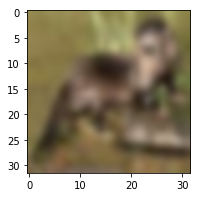

In [8]:
def plot_CIFAR(image):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(image,interpolation='bicubic')
plot_CIFAR(images[100])

In [0]:
train_image = train_data.iloc[:,:-1].values
R = train_image[:,0:1024].reshape(train_image.shape[0],32,32)
G = train_image[:,1024:2048].reshape(train_image.shape[0],32,32)
B = train_image[:,2048:3072].reshape(train_image.shape[0],32,32)
images = np.stack((R.T,G.T,B.T),axis=0).T

In [9]:

images = images.astype("float32")
mean = np.mean(images,axis=(0,1,2,3))
std = np.std(images,axis=(0,1,2,3))
images = (images)/255
print(images.shape,images[0].shape)

(50000, 32, 32, 3) (32, 32, 3)


In [11]:
k = 40000
X_train = images[:k]
X_val = images[k:]
Y_train_class = train_data.iloc[:k,-1].values
Y_val_class = train_data.iloc[k:,-1].values
Y_val_class = to_categorical(train_data.iloc[k:,-1].values).reshape(train_data.shape[0]-k,100)
Y_train_class = to_categorical(train_data.iloc[:k,-1].values).reshape(k,100) 
Y_train_group = train_data.iloc[:k,-2].values
Y_val_group = train_data.iloc[k:,-2].values
Y_val_group = to_categorical(train_data.iloc[k:,-2].values).reshape(train_data.shape[0]-k,20)
Y_train_group = to_categorical(train_data.iloc[:k,-2].values).reshape(k,20) 
print(R.shape,G.shape,B.shape,X_train.shape,Y_train_class.shape,Y_train_group.shape,X_val.shape,Y_val_class.shape,Y_val_group.shape)


(50000, 32, 32) (50000, 32, 32) (50000, 32, 32) (40000, 32, 32, 3) (40000, 100) (40000, 20) (10000, 32, 32, 3) (10000, 100) (10000, 20)


In [12]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    )
datagen.fit(X_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
def lr_scheduler(epoch):
  learning_rate = 1e-3
  if (epoch>180):
    learning_rate*=.5e-3
  elif(epoch>160):
    learning_rate*=1e-3
  elif(epoch>120):
    learning_rate*=1e-2
  elif(epoch>80):
    learning_rate*=1e-1
  return learning_rate
    

In [0]:
def vgg(X_train):
  inputs = Input(shape=X_train[0].shape)
  x = Conv2D(filters=32, kernel_size=(3,3),kernel_initializer=glorot_uniform(seed=0),activation="relu",padding="same")(inputs)
  x = Conv2D(filters=32, kernel_size=(3,3),kernel_initializer=glorot_uniform(seed=0),activation="relu",padding="same")(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Conv2D(filters=64, kernel_size=(3,3),kernel_initializer=glorot_uniform(seed=0),activation="relu",padding="same")(x)
  x = Conv2D(filters=64, kernel_size=(3,3),kernel_initializer=glorot_uniform(seed=0),activation="relu",padding="same")(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Conv2D(filters=128, kernel_size=(3,3),kernel_initializer=glorot_uniform(seed=0),activation="relu",padding="same")(x)
  x = Conv2D(filters=128, kernel_size=(3,3),kernel_initializer=glorot_uniform(seed=0),activation="relu",padding="same")(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(128,activation="relu",kernel_initializer=glorot_uniform(seed=0))(x)
  x = Dense(10,activation="softmax")(x)
  model = Model(inputs=inputs,output=x)
  return model


In [0]:
def resnet20(X_train):
  inputs = Input(shape=X_train[0].shape)
  x = Conv2D(filters=16,kernel_size=(3,3),strides=1,padding="same",activation="relu")(inputs)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  
  x = id_block_50([16,16],3,x)
  x = id_block_50([16,16],3,x)
  x = id_block_50([16,16],3,x)
  
  x = conv_block_50([32,32],3,x,2)
  x = id_block_50([32,32],3,x)
  x = id_block_50([32,32],3,x)


  x = conv_block_50([64,64],3,x,2)
  x = id_block_50([64,64],3,x)
  x = id_block_50([64,64],3,x)
  x = AveragePooling2D(pool_size=(8,8))(x)
  x = Flatten()(x)
  x = Dense(10,activation="softmax")(x)
  model = Model(inputs = inputs, output=x)
  return model

In [0]:
def conv_block_50(filters,f,X_last,s):

  x = Conv2D(filters=filters[0],kernel_size=(3,3),strides=(s,s),padding="same",kernel_initializer=glorot_uniform(seed=0))(X_last)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  x = Conv2D(filters=filters[1],kernel_size=(3,3),strides=(1,1),padding="same",kernel_initializer=glorot_uniform(seed=0))(x)
  X_last = Conv2D(filters=filters[1],kernel_size=(3,3),strides=(s,s),padding="same",kernel_initializer=glorot_uniform(seed=0))(X_last)
  x = BatchNormalization(axis=3)(x)

  x = Add()([x,X_last])
  x = Activation(activation="relu")(x)
  return x
  


In [0]:
def id_block_50(filters,f,X_last):

  x = Conv2D(filters=filters[0],kernel_size=(f,f),strides=(1,1),padding="same",kernel_initializer=glorot_uniform(seed=0))(X_last)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  x = Conv2D(filters=filters[1],kernel_size=(f,f),strides=(1,1),padding="same",kernel_initializer=glorot_uniform(seed=0))(x)
  x = BatchNormalization(axis=3)(x)
  # x = Activation(activation="relu")(x)
  x = Add()([x,X_last])
  x = Activation(activation="relu")(x)
  return x
  

In [0]:
def id_block(filters,f,X_last):

  x = Conv2D(filters=filters[0],kernel_size=(1,1),strides=(1,1),padding="valid",kernel_initializer=glorot_uniform(seed=0))(X_last)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  x = Conv2D(filters=filters[1],kernel_size=(f,f),strides=(1,1),padding="same",kernel_initializer=glorot_uniform(seed=0))(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  x = Conv2D(filters=filters[2],kernel_size=(1,1),strides=(1,1),padding="valid",kernel_initializer=glorot_uniform(seed=0))(x)
  x = BatchNormalization(axis=3)(x)
  x = Add()([x,X_last])
  x = Activation(activation="relu")(x)
  return x
  

In [0]:
def conv_block(filters,f,X_last,s):

  x = Conv2D(filters=filters[0],kernel_size=(1,1),strides=(s,s),padding="valid",kernel_initializer=glorot_uniform(seed=0))(X_last)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  x = Conv2D(filters=filters[1],kernel_size=(f,f),strides=(1,1),padding="same",kernel_initializer=glorot_uniform(seed=0))(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation="relu")(x)
  x = Conv2D(filters=filters[2],kernel_size=(1,1),strides=(1,1),padding="valid",kernel_initializer=glorot_uniform(seed=0))(x)
  x = BatchNormalization(axis=3)(x)
  
  X_last = Conv2D(filters=filters[2],kernel_size=(1,1),strides=(s,s),padding="valid",kernel_initializer=glorot_uniform(seed=0))(X_last)
  X_last = BatchNormalization(axis=3)(X_last)

  x = Add()([x,X_last])
  x = Activation(activation="relu")(x)
  return x
  


In [19]:
model = Sequential()
model.add(Conv2D(96, kernel_size=3, strides = 1, padding='same', activation ='relu', input_shape=(32,32,3)))
model.add(Dropout(0.5))
model.add(Conv2D(96, kernel_size=3, strides = 1, padding='same', activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(96, kernel_size=3, strides = 2, padding='same', activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(192, kernel_size=3, strides = 1, padding='same', activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(192, kernel_size=3, strides = 1, padding='same', activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(192, kernel_size=3, strides = 2, padding='same', activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(192, kernel_size=3, strides = 1, padding='same', activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(192, kernel_size=1, strides = 1, padding='same', activation ='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(100, kernel_size=1, strides = 1, padding='same', activation ='relu'))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 192)      

In [20]:
model.fit(X_train, Y_train_class, validation_data=(X_val, Y_val_class), epochs=70)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/70





40000/40000 [==============================] - 82s 2ms/step - loss: 4.5976 - acc: 0.0118 - val_loss: 4.5681 - val_acc: 0.0173
Epoch 2/70
40000/40000 [==============================] - 70s 2ms/step - loss: 4.5324 - acc: 0.0164 - val_loss: 4.4987 - val_acc: 0.0190
Epoch 3/70
40000/40000 [==============================] - 71s 2ms/step - loss: 4.4143 - acc: 0.0303 - val_loss: 4.2645 - val_acc: 0.0494
Epoch 4/70
40000/40000 [==============================] - 70s 2ms/step - loss: 4.1529 - acc: 0.0520 - val_loss: 3.9956 - val_acc: 0.0756
Epoch 5/70
40000/40000 [==============================] - 70s 2ms/step - loss: 3.9495 - acc: 0.0809 - val_loss: 3.7769 - val_acc: 0.1192
Epoch 6/70
40000/40000 [==============================] - 70s 2ms/step - loss: 3.7789 - acc: 0.1106 - val_loss: 3.6191 - val_acc: 0.1457
Epoch 7/70
40000/40000 [==